In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from model import ScoreTransformer

import yaml
import argparse
import os
import pickle
from einops import rearrange

In [3]:
import re, music21

In [4]:
import IPython.display


In [5]:
from preprocessing import *

In [6]:
from dataset import *

In [7]:
def show_score(pm):
    pm.write('./temp.mid')
    stream = music21.converter.parse('./temp.mid')
    stream.show()


def setup_musescore(musescore_path=None):
    if not is_ipython(): return

    import platform
    from music21 import environment
    from pathlib import Path

    system = platform.system()
    if system == 'Linux':
        import os
        os.environ['QT_QPA_PLATFORM'] = 'offscreen'  # https://musescore.org/en/node/29041

    existing_path = environment.get('musicxmlPath')
    if existing_path: return
    if musescore_path is None:
        if system == 'Darwin':
            app_paths = list(Path('/Applications').glob('MuseScore *.app'))
            if len(app_paths): musescore_path = app_paths[-1] / 'Contents/MacOS/mscore'
        elif system == 'Linux':
            musescore_path = '/usr/bin/musescore'

    if musescore_path is None or not Path(musescore_path).exists():
        print(
            'Warning: Could not find musescore installation. Please install musescore (see README) and/or update music21 environment paths')
    else:
        environment.set('musicxmlPath', musescore_path)
        environment.set('musescoreDirectPNGPath', musescore_path)


def is_ipython():
    try:
        get_ipython
    except:
        return False
    return True


def is_colab():
    try:
        import google.colab
    except:
        return False
    return True

In [8]:
setup_musescore()

In [9]:
span_ratio_separately_each_epoch = np.array([[1, 0, 0], [.5, .5, 0],
                                             [.25, .75, 0], [.25, .5, .25],
                                             [.25, .25, .5]])

def gen_nopeek_mask(length):
    """
     Returns the nopeek mask
             Parameters:
                     length (int): Number of tokens in each sentence in the target batch
             Returns:
                     mask (arr): tgt_mask, looks like [[0., -inf, -inf],
                                                      [0., 0., -inf],
                                                      [0., 0., 0.]]
     """
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    return mask


def softmax_with_temperature(logits, temperature):
    probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
    return probs


def weighted_sampling(probs):
    probs /= sum(probs)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    word = np.random.choice(sorted_index, size=1, p=sorted_probs)[0]
    return word


def nucleus(probs, p):
    probs /= (sum(probs) + 1e-5)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    cusum_sorted_probs = np.cumsum(sorted_probs)
    after_threshold = cusum_sorted_probs > p
    if sum(after_threshold) > 0:
        last_index = np.where(after_threshold)[0][0] + 1
        candi_index = sorted_index[:last_index]
    else:
        candi_index = sorted_index[:]
    candi_probs = [probs[i] for i in candi_index]
    candi_probs /= sum(candi_probs)
    word = np.random.choice(candi_index, size=1, p=candi_probs)[0]
    return word


def sampling(logit, p=None, t=1.0):
    logit = logit.squeeze().cpu().numpy()
    probs = softmax_with_temperature(logits=logit, temperature=t)

    if p is not None:
        cur_word = nucleus(probs, p=p)
    else:
        cur_word = weighted_sampling(probs)
    return cur_word

In [10]:
platform = 'local'
checkpoint_epoch = 19
config_folder = '/home/ruiguo/score_transformer/wandb/run-20210131_170940-20n3sybv/'


In [11]:
platform = 'local'
checkpoint_epoch = 9
config_folder = '/home/ruiguo/score_transformer/wandb/run-20210202_182127-1kygswys/'


In [12]:
vocab = WordVocab(all_tokens)
with open(os.path.join(config_folder,"files/config.yaml")) as file:

    config = yaml.full_load(file)


vocab size: 330


In [13]:
model = ScoreTransformer(vocab.vocab_size, config['d_model']['value'], config['nhead']['value'], config['num_encoder_layers']['value'],
                                 config['num_encoder_layers']['value'], 2048, 2400,
                                 0.1, 0.1)

checkpoint = os.path.join(config_folder,f"files/checkpoint_{checkpoint_epoch}")
model_dict = torch.load(checkpoint)

model_state = model_dict['model_state_dict']
optimizer_state = model_dict['optimizer_state_dict']

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in model_state.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v

# new_state_dict = model_state

model.load_state_dict(new_state_dict)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

window_size = int(16 / 2)

if platform == 'local':
    folder_prefix = '/home/ruiguo/'
else:
    folder_prefix = '/content/drive/MyDrive/'


test_batch_name = 'test_batches_0_0_1_new_bins'
test_length_name = 'test_batch_lengths_0_0_1_new_bins'


test_batches = pickle.load(open(folder_prefix + 'score_transformer/' + test_batch_name, 'rb'))

test_batch_lengths = pickle.load(open(folder_prefix + 'score_transformer/' + test_length_name, 'rb'))


print(f'test batch length is {len(test_batches)}')

ce_weight = torch.ones(vocab.vocab_size, device=device)
ce_weight[0] = 0
ce_weight[1] = 1
ce_weight[1] = 1
ce_weight[11:18] = 0
ce_weight[170:234] = 0
ce_loss = nn.CrossEntropyLoss(ignore_index=0, weight=ce_weight, reduction='none')

ce_weight_all = torch.ones(vocab.vocab_size, device=device)
ce_weight_all[0] = 0

tempo_weight = torch.zeros(vocab.vocab_size, device=device)
tempo_weight[11:18] = 1
tempo_loss = nn.CrossEntropyLoss(ignore_index=0, weight=tempo_weight, reduction='none')

density_weight = torch.zeros(vocab.vocab_size, device=device)
density_weight[170:180] = 1
density_loss = nn.CrossEntropyLoss(ignore_index=0, weight=density_weight, reduction='none')

occupation_weight = torch.zeros(vocab.vocab_size, device=device)
occupation_weight[180:190] = 1
occupation_loss = nn.CrossEntropyLoss(ignore_index=0, weight=occupation_weight, reduction='none')

polyphony_weight = torch.zeros(vocab.vocab_size, device=device)
polyphony_weight[190:200] = 1
polyphony_loss = nn.CrossEntropyLoss(ignore_index=0, weight=polyphony_weight, reduction='none')

pitch_register_weight = torch.zeros(vocab.vocab_size, device=device)
pitch_register_weight[200:210] = 1
pitch_register_loss = nn.CrossEntropyLoss(ignore_index=0, weight=pitch_register_weight, reduction='none')

tensile_weight = torch.zeros(vocab.vocab_size, device=device)
tensile_weight[210:222] = 1
tensile_loss = nn.CrossEntropyLoss(ignore_index=0, weight=tensile_weight, reduction='none')

diameter_weight = torch.zeros(vocab.vocab_size, device=device)
diameter_weight[222:234] = 1
diameter_loss = nn.CrossEntropyLoss(ignore_index=0, weight=diameter_weight, reduction='none')


test batch length is 1235


In [14]:
test_dataset = ParallelLanguageDataset('', '',
                                       vocab, 0,
                                       0,
                                       2400,
                                       window_size,
                                       test_batches,
                                       test_batch_lengths,
                                       config['batch_size']['value'],
                                       .15,
                                       .3,
                                       .3,
                                       .3,
                                       .9,
                                       .3,
                                       3,
                                       0.5,
                                       span_ratio_separately_each_epoch,
                                       mask_bar_num_ratio=[0,0,0,0,
                                                                    0,0,0,0,
                                                                    0,0,1,1,
                                                                    1,1,1,1],
                                       mask_track_num_ratio=[[0, 0, 1], [.5, .5]],
                                       mask_bar_ctrl_token=False,
                                       pretraining=False,
                                       train_jointly=True,
                                       verbose=True)

test_data_loader = DataLoader(test_dataset, batch_size=1,
                              collate_fn=lambda batch: collate_mlm(batch))


pretraining is False
mask_bar_num_ratio is ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],)
mask_track_num_ratio is ([[0, 0, 1], [0.5, 0.5]],)
mask_bar_ctrl_token is (False,)


In [15]:

def model_generate(model, src, tgt):

    src = src.clone().detach().unsqueeze(0).long().to('cuda')
    tgt = torch.tensor(tgt).unsqueeze(0).to('cuda')
    tgt_mask = gen_nopeek_mask(tgt.shape[1])
    tgt_mask = tgt_mask.clone().detach().unsqueeze(0).to('cuda')


    output = model.forward(src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None,
                           tgt_mask=tgt_mask)

    return output.squeeze(0).to('cpu')

In [63]:
def restore_marked_input(src_token,generated_output,target_output):
    src_token = np.array(src_token)
    
    # restore with generated output
    restored_with_generated_token = src_token.copy()

    generated_output = np.array(generated_output)
    target_output = np.array(target_output)
    generation_mask_indices = np.where(generated_output == 'm_0')[0]
    
    
    if len(generation_mask_indices) == 1:
        
        mask_indices = np.where(restored_with_generated_token == 'm_0')[0]
        generated_result_sec = generated_output[generation_mask_indices[0]+1:]

#         print(len(generated_result_sec))
        restored_with_generated_token = np.delete(restored_with_generated_token,mask_indices[0])
        for token in generated_result_sec[::-1]:
#             print(token)
            restored_with_generated_token = np.insert(restored_with_generated_token,mask_indices[0],token)
            
    
    else:
    
    
        for i in range(len(generation_mask_indices)-1):
    #         print(i)
            mask_indices = np.where(restored_with_generated_token == 'm_0')[0]
            generated_result_sec = generated_output[generation_mask_indices[i]+1:generation_mask_indices[i+1]]

#             print(len(generated_result_sec))
#             print(mask_indices[i])
            restored_with_generated_token = np.delete(restored_with_generated_token,mask_indices[0])


            for token in generated_result_sec[::-1]:
#                 print(token)
                restored_with_generated_token = np.insert(restored_with_generated_token,mask_indices[0],token)

        else:
    #         print(i)
            mask_indices = np.where(restored_with_generated_token == 'm_0')[0]
            generated_result_sec = generated_output[generation_mask_indices[i+1]+1:]

#             print(len(generated_result_sec))
            restored_with_generated_token = np.delete(restored_with_generated_token,mask_indices[0])
            for token in generated_result_sec[::-1]:
#                 print(token)
                restored_with_generated_token = np.insert(restored_with_generated_token,mask_indices[0],token)

    
    
    # restore with target 
    r = re.compile('track_\d')
    target_mask_names = list(filter(r.match, target_output))
    target_output = np.array(target_output)
    if '<pad>' in target_output:
        end_index = np.where(target_output == '<pad>')[0][0]
    else:
        end_index = len(target_output)
    target_output = target_output.tolist()
    start_index = 0
    target_mask_indices = []

    for name in target_mask_names:
        result_pos = target_output.index(name, start_index, end_index)
        target_mask_indices.append(result_pos)
        start_index = result_pos
#     print(target_mask_indices)
    restored_with_target_token = src_token.copy()
    
    if len(target_mask_indices) == 1:
        mask_indices = np.where(restored_with_target_token == 'm_0')[0]
        target_result_sec = target_output[target_mask_indices[0]:end_index-1]

#         print(len(target_result_sec))
        restored_with_target_token = np.delete(restored_with_target_token,mask_indices[0])
        for token in target_result_sec[::-1]:
#             print(token)
            restored_with_target_token = np.insert(restored_with_target_token,mask_indices[0],token)       
            
    else:   
        for i in range(len(target_mask_indices)-1):

            mask_indices = np.where(restored_with_target_token == 'm_0')[0]
            
            
            #print(f'len(mask_indices) {len(mask_indices)}')
            #print(f'i={i}')
            #print(f'target_mask_indices={target_mask_indices}')
            target_result_sec = target_output[target_mask_indices[i]:target_mask_indices[i+1]-1]

#             print(len(target_result_sec))
#             print(mask_indices[i])
            restored_with_target_token = np.delete(restored_with_target_token,mask_indices[0])
            for token in target_result_sec[::-1]:
#                 print(token)
                restored_with_target_token = np.insert(restored_with_target_token,mask_indices[0],token)

        else:
            mask_indices = np.where(restored_with_target_token == 'm_0')[0]
            #print(f'len(mask_indices) {len(mask_indices)}')
            #print(f'i={i}')
            #print(f'target_mask_indices={target_mask_indices}')
            target_result_sec = target_output[target_mask_indices[i+1]:end_index-1]

#             print(len(target_result_sec))
            restored_with_target_token = np.delete(restored_with_target_token,mask_indices[0])
            for token in target_result_sec[::-1]:
#                 print(token)
                restored_with_target_token = np.insert(restored_with_target_token,mask_indices[0],token)       

            
    # restore with rest
    
    if src_token[1] == '4/4':
        fill_in_tokens = ['rest_e','whole']
    elif src_token[1] == '2/4':
        fill_in_tokens = ['rest_e','half']
    else:
        fill_in_tokens = ['rest_e','half','quarter']
    #print(fill_in_tokens)
        
    mask_indices = np.where(src_token == 'm_0')[0]
    restored_empty_fill = src_token.copy()
    #print(restored_empty_fill)
    
    for i in range(len(mask_indices)):
#         print(target_mask_names)
        mask_indices = np.where(restored_empty_fill == 'm_0')[0]
#         print(mask_indices)
        restored_empty_fill = np.delete(restored_empty_fill,mask_indices[0])

        for token in fill_in_tokens[::-1]:
            #print(token)
            restored_empty_fill = np.insert(restored_empty_fill,mask_indices[0],token)
        restored_empty_fill = np.insert(restored_empty_fill,mask_indices[0],target_mask_names[i])
       # print(target_mask_names[i])
    
    # print where is masked
    bar_pos = np.where(src_token == 'bar')[0]
    
    mask_indices = np.where(src_token == 'm_0')[0]
    #print(f'mask_indices positions are {mask_indices}')
    r = re.compile('track_\d')

    track_names= list(filter(r.match, target_output))

    for i,index in enumerate(mask_indices):
        if index > bar_pos[-1]:
            print(f'masked bar {len(bar_pos)} {track_names[i]}')
        else:
            bar_start_index = np.where(index < bar_pos)[0][0]
            print(f'masked bar {bar_start_index} {track_names[i]}')

    return restored_with_generated_token,restored_with_target_token,restored_empty_fill

In [64]:
def mask_bar_and_track(event,mask_bars=0,mask_tracks=0,mask_bar_ctr=False):

    # mask bar token (w/wo bar control token) and try to generate bar token

    total_tokens = []
    total_decoder_in = []
    total_decoder_target = []

    
    
    tokens = []
    decoder_in = []
    decoder_target = []
    masked_indices_pairs = []

    bar_pos = np.where(np.array(event) == 'bar')[0]

    r = re.compile('i_\d')

    track_program = list(filter(r.match, event))
    track_nums = len(track_program)


    if track_nums == 3:
#         ratios = track_ratio[0]
        track_0_pos = np.where('track_0' == np.array(event))[0]
        track_1_pos = np.where('track_1' == np.array(event))[0]
        track_2_pos = np.where('track_2' == np.array(event))[0]
        all_track_pos = np.sort(np.concatenate([track_0_pos, track_1_pos, track_2_pos]))

    else:
#         ratios = track_ratio[1]
        track_0_pos = np.where('track_0' == np.array(event))[0]
        track_1_pos = np.where('track_1' == np.array(event))[0]
        all_track_pos = np.sort(np.concatenate([track_0_pos, track_1_pos]))
    
#     bar_number_prob = np.array(bar_ratio[:len(bar_pos)],dtype=float)
#     if not np.any(bar_number_prob):
#         bar_number_prob = np.ones(len(bar_pos))

#     print(f'bar number prob is {bar_number_prob}')
#     bar_number_prob /= np.sum(bar_number_prob)

#     # if np.sum(bar_number_prob) != 1:
#     #     print(bar_number_prob)
#     # print(f'bar number prob is {bar_number_prob}')
#     resample_counts = np.random.multinomial(1, bar_number_prob[:len(bar_pos)])
#     bar_mask_number = np.where(resample_counts)[0][0] + 1
#     # bar_mask_number = np.random.choice(range(len(bar_pos)), size=1, p=bar_ratio[:len(bar_pos)])
#     bar_start_indices = np.sort(np.random.choice(len(bar_pos),size=bar_mask_number,replace=False))
    
    
    if not mask_bars:
        mask_bars = len(bar_pos)
    if not mask_tracks:
        mask_tracks = track_num
    #print(f'bar start indices is {bar_start_indices}')
    for i, bar_num in enumerate(mask_bars):
        # bar_start_index = np.random.choice(len(bar_pos))


        if bar_num == len(bar_pos) - 1:
            next_bar_start_pos = len(event)
        else:
            next_bar_num = bar_num + 1
            next_bar_start_pos = bar_pos[next_bar_num]

        bar_start_pos = bar_pos[bar_num]


        track_start_index = np.where(all_track_pos > bar_start_pos)[0][0]
        track_positions = all_track_pos[track_start_index:track_start_index + track_num]

        track_positions = np.append(track_positions, next_bar_start_pos)

#         prob = random.random()
#         # print(prob)
#         if prob < ratios[0]:
#             # select one track
#             track_pos_select_index = [np.random.choice(track_num)]
#         elif prob < ratios[0] + ratios[1]:
#             # select two tracks
#             track_pos_select_index = np.sort(np.random.choice(track_num, 2, replace=False))
#         else:
#             # select three tracks
#             track_pos_select_index = np.arange(track_num)
        #print(track_nums)
        #print(bar_start_index)
        track_pos_select_index = mask_tracks[i]

        
        print(f'mask bar {bar_num + 1} track {track_pos_select_index}')

        for track_pos_index in track_pos_select_index:

            track_start_pos = track_positions[track_pos_index]
            if track_pos_index + 1 == len(track_positions):
                print('why')
            track_end_pos = track_positions[track_pos_index + 1]
            # print(track_start_pos)
            # print(track_end_pos)
            masked_indices_pairs.append((track_start_pos,track_end_pos))
            # track_event = event[track_start_pos:track_end_pos]
            # print(track_event)

    token_events = event.copy()

    for masked_pairs in masked_indices_pairs:
        masked_token = event[masked_pairs[0]:masked_pairs[1]]
        # print(masked_token)
        decoder_in.append(vocab.mask_indices[0])
        for token in masked_token:
            decoder_in.append(vocab.char2index(token))
            decoder_target.append(vocab.char2index(token))
        else:
            decoder_target.append(vocab.eos_index)

    for masked_pairs in masked_indices_pairs[::-1]:
        # print(masked_pairs)
        # print(token_events[masked_pairs[0]:masked_pairs[1]])
        for pop_time in range(masked_pairs[1] - masked_pairs[0]):
            token_events.pop(masked_pairs[0])
        token_events.insert(masked_pairs[0], mask[0])

    for token in token_events:
        tokens.append(vocab.char2index(token))

    tokens = np.array(tokens)
    if len(decoder_in) > 0:
        decoder_in = np.array(decoder_in)
        decoder_target = np.array(decoder_target)
        # print('\n')
        # print(f'event length is {len(event)}')
        # print(f'tokens length is {len(tokens)}')
        # print(f'masked num is {masked_num}')
        # print(f'decoder_in length is {len(decoder_in)}')
        # print(f'decoder_out length is {len(decoder_target)}')
        # print(f'ratio is {(len(tokens) + len(decoder_in)) / len(event)}')
        total_tokens.append(tokens)
        total_decoder_in.append(decoder_in)
        total_decoder_target.append(decoder_target)







    # print(len(tokens) - len(np.where(output_label==2)[0]))
    # print(len(output_label) - len(np.where(output_label==2)[0])*2)
    return torch.tensor(total_tokens).long().squeeze(),torch.tensor(total_decoder_target).long().squeeze()


In [65]:
bar_nums = [2,3,4,6,14]
track_nums = [[0,1,2],[0,1,2],[0,1,2],[1,2],[1,2]]

src,tgt_out = mask_bar_and_track(restored_with_target_token.tolist(),bar_nums,track_nums)
src.to(device)
tgt_out.to(device)

src_masked_track = torch.sum(src == vocab.char2index('m_0')).item()
tgt_inp = []
with torch.no_grad():
    for _ in range(src_masked_track):
        #i = 0
        tgt_inp.append(vocab.char2index('m_0'))
        while tgt_inp[-1] != vocab.char2index('<eos>'):
            output = model_generate(model, src, tgt_inp).to(device)
            index = sampling(output[-1], 0.9)
    #                     print(index)
            tgt_inp.append(index)
            #i += 1
generated_output = []
target_output = []
src_token = []

for i, token_idx in enumerate(tgt_inp):
    output_token = vocab.index2char(token_idx)
    generated_output.append(output_token)


for i, token_idx in enumerate(tgt_out):
    target_token = vocab.index2char(token_idx.item())
    target_output.append(target_token)


# print(f'generation {generated_output}')
#print(f'target {target_output}')

for i, token_idx in enumerate(src):  
    src_token.append(vocab.index2char(token_idx.item()))
restored_with_generated_token,restored_with_target_token,restored_empty_fill = restore_marked_input(src_token,generated_output,target_output)



    



mask bar 3 track [0, 1, 2]
mask bar 4 track [0, 1, 2]
mask bar 5 track [0, 1, 2]
mask bar 7 track [1, 2]
mask bar 15 track [1, 2]
masked bar 3 track_0
masked bar 3 track_1
masked bar 3 track_2
masked bar 4 track_0
masked bar 4 track_1
masked bar 4 track_2
masked bar 5 track_0
masked bar 5 track_1
masked bar 5 track_2
masked bar 7 track_2
masked bar 7 track_0
masked bar 14 track_1
masked bar 14 track_2


In [66]:
pm0,_ = event_2midi(restored_empty_fill.tolist())
IPython.display.Audio(pm0.fluidsynth(fs=16000), rate=16000)


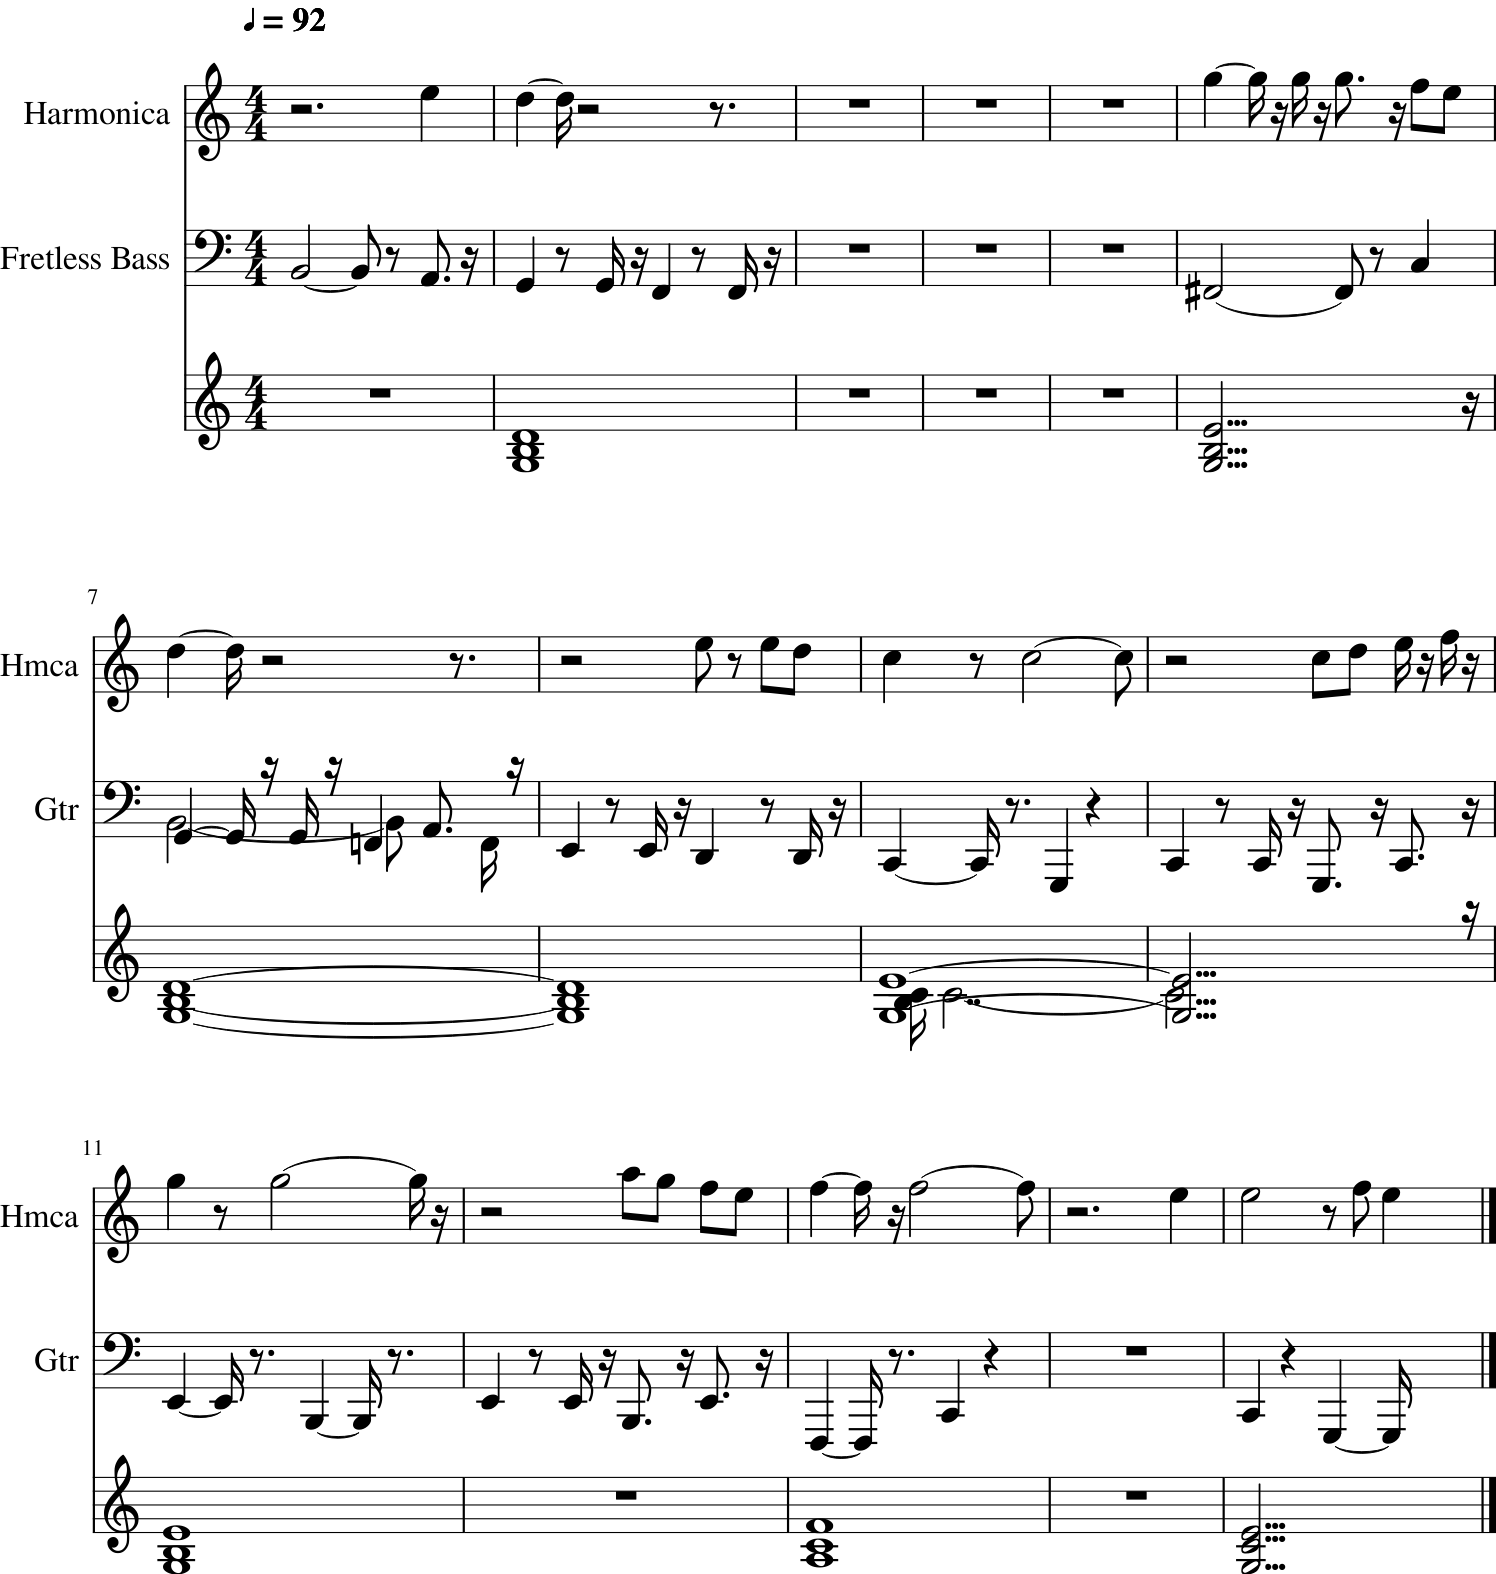

In [67]:
show_score(pm0)

In [68]:
pm1,_ = event_2midi(restored_with_target_token.tolist())
IPython.display.Audio(pm1.fluidsynth(fs=16000), rate=16000)


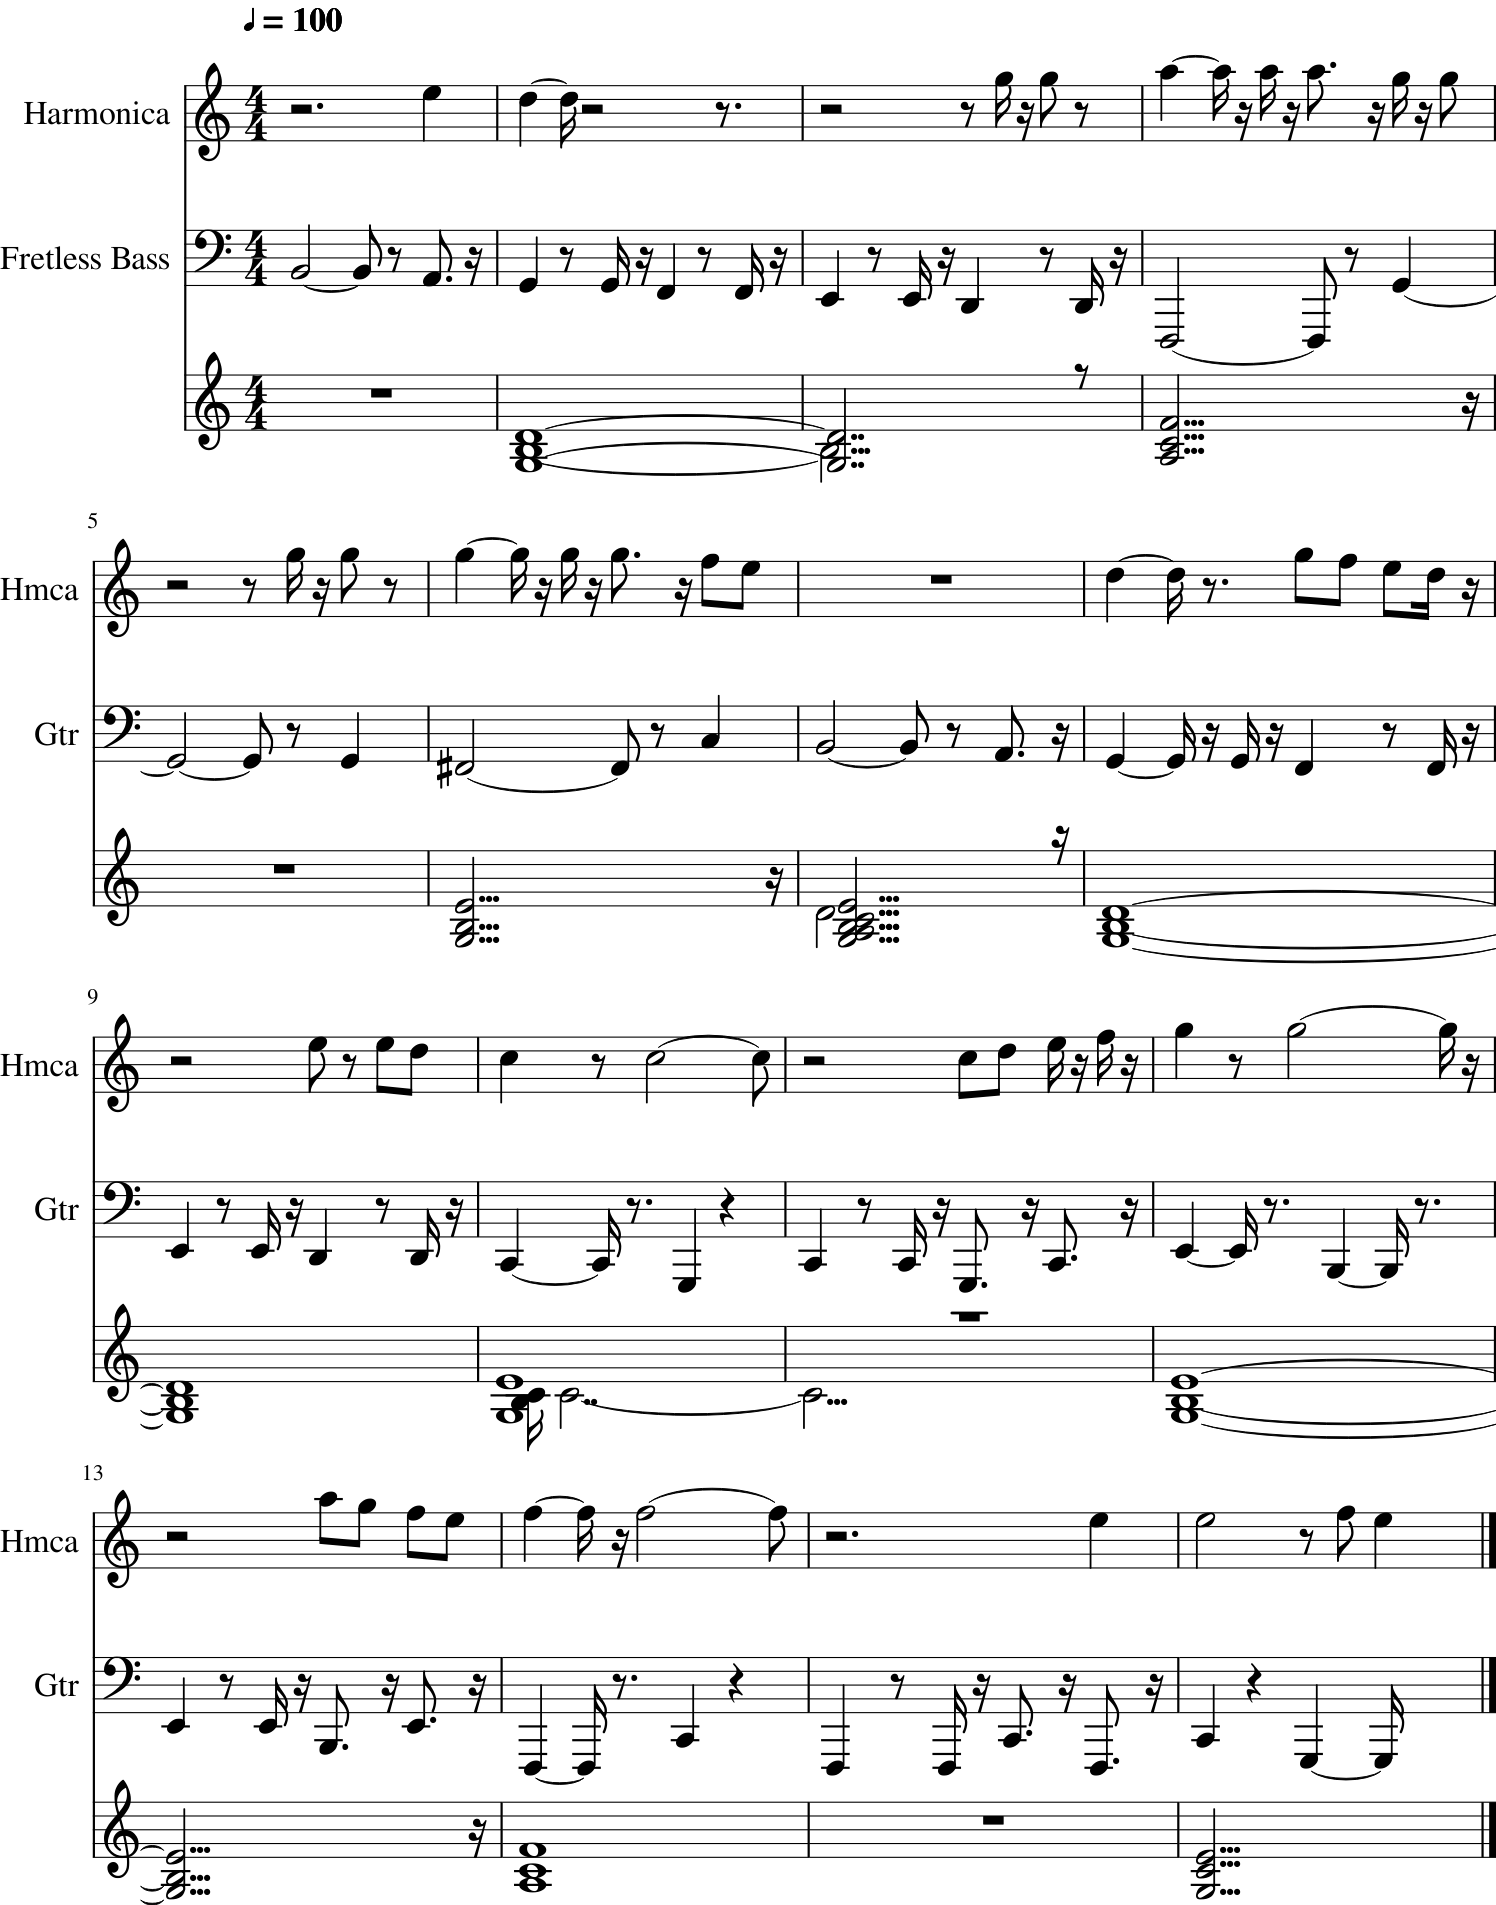

In [69]:
show_score(pm1)

In [72]:
pm2,_ = event_2midi(restored_with_generated_token.tolist())
IPython.display.Audio(pm2.fluidsynth(fs=16000), rate=16000)


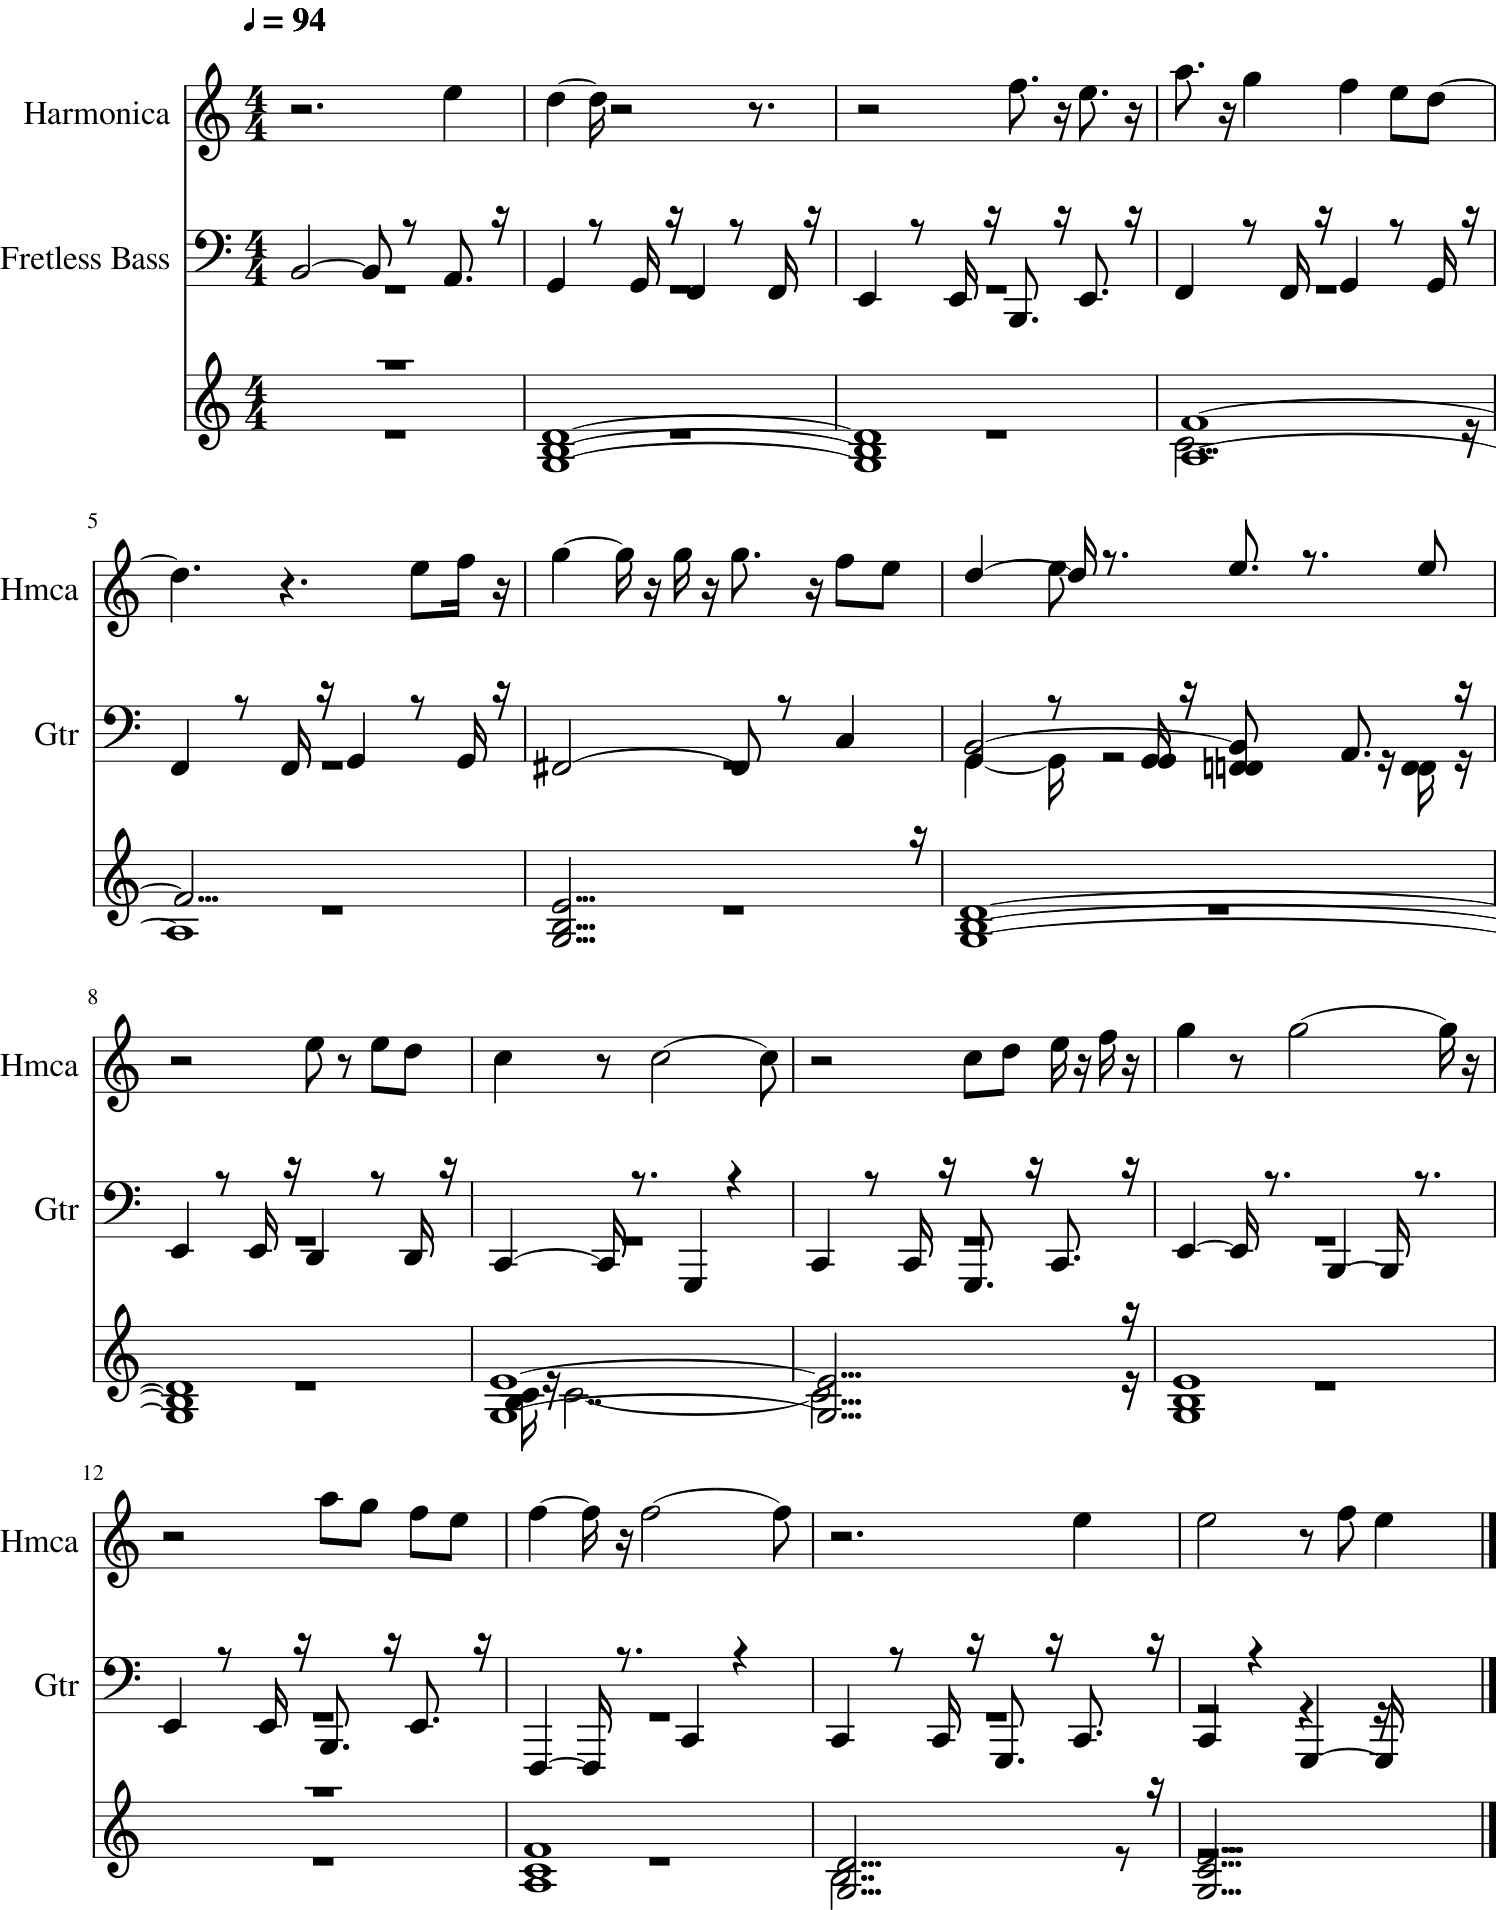

In [73]:
show_score(pm2)

In [90]:
src_token = []
for i, token_idx in enumerate(src):  
    src_token.append(vocab.index2char(token_idx.item()))

In [91]:
src_token = np.array(src_token)

In [98]:
result_token = src_token.copy()

In [80]:
generated_output = np.array(generated_output)
target_output = np.array(target_output)

In [124]:
r = re.compile('track_\d')

In [138]:
target_mask_names = list(filter(r.match, target_output))
target_output = np.array(target_output)
end_index = np.where(target_output == '<pad>')[0][0]
target_output = target_output.tolist()
start_index = 0
target_mask_indices = []

for name in target_mask_names:
    result_pos = target_output.index(name, start_index, end_index)
    target_mask_indices.append(result_pos)
    start_index = result_pos
    

In [139]:
target_mask_indices

[0, 30, 52]

In [144]:
result_token

array(['bar', '4/4', 't_2', ..., 'p_61', 'p_64', 'half'], dtype='<U9')

In [148]:
np.where(src_token == 'm_0')[0]

array([21, 22, 23])

In [152]:
result_token = src_token.copy()
for i in range(len(target_mask_indices)-1):
    mask_indices = np.where(result_token == 'm_0')[0]
    target_result_sec = target_output[target_mask_indices[i]:target_mask_indices[i+1]-1]
    
    print(len(target_result_sec))
    print(mask_indices[i])
    result_token = np.delete(result_token,mask_indices[0])
    for token in target_result_sec[::-1]:
        print(token)
        result_token = np.insert(result_token,mask_indices[0],token)
    
else:
    mask_indices = np.where(result_token == 'm_0')[0]
    target_result_sec = target_output[target_mask_indices[i+1]:end_index-1]
    
    print(len(target_result_sec))
    result_token = np.delete(result_token,mask_indices[0])
    for token in target_result_sec[::-1]:
        print(token)
        result_token = np.insert(result_token,mask_indices[0],token)

29
21
sixteenth
p_71
sixteenth
p_70
sixteenth
rest_e
sixteenth
p_68
sixteenth
rest_e
eighth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
eighth
rest_e
track_0
21
51
sixteenth
eighth
rest_e
sixteenth
p_39
sixteenth
p_39
sixteenth
rest_e
eighth
p_39
eighth
rest_e
eighth
p_35
sixteenth
p_35
sixteenth
eighth
p_35
track_1
15
half
p_61
p_58
half
rest_s
sixteenth
eighth
quarter
half
p_54
rest_s
half
p_59
p_63
track_2


In [153]:
result_token[21:90]

array(['track_0', 'rest_e', 'eighth', 'p_66', 'sixteenth', 'rest_e',
       'sixteenth', 'p_66', 'sixteenth', 'rest_e', 'sixteenth', 'p_66',
       'sixteenth', 'p_66', 'sixteenth', 'rest_e', 'sixteenth', 'p_66',
       'eighth', 'rest_e', 'sixteenth', 'p_68', 'sixteenth', 'rest_e',
       'sixteenth', 'p_70', 'sixteenth', 'p_71', 'sixteenth', 'track_1',
       'p_35', 'eighth', 'sixteenth', 'p_35', 'sixteenth', 'p_35',
       'eighth', 'rest_e', 'eighth', 'p_39', 'eighth', 'rest_e',
       'sixteenth', 'p_39', 'sixteenth', 'p_39', 'sixteenth', 'rest_e',
       'eighth', 'sixteenth', 'track_2', 'p_63', 'p_59', 'half', 'rest_s',
       'p_54', 'half', 'quarter', 'eighth', 'sixteenth', 'rest_s', 'half',
       'p_58', 'p_61', 'half', 'bar', 's_4', 'a_10', 'track_0'],
      dtype='<U9')

In [96]:
mask_indices = np.where(src_token == 'm_0')[0]

In [97]:
mask_indices

array([21, 22, 23])

In [83]:
generation_mask_indices = np.where(generated_output == 'm_0')[0]

In [89]:
generation_mask_indices

array([ 0, 31, 56])

In [99]:
for i in range(len(generation_mask_indices)-1):
    mask_indices = np.where(result_token == 'm_0')[0]
    generated_result_sec = generated_output[generation_mask_indices[i]+1:generation_mask_indices[i+1]]
    
    print(len(generated_result_sec))
    print(mask_indices[i])
    result_token = np.delete(result_token,mask_indices[0])
    for token in generated_result_sec[::-1]:
        print(token)
        result_token = np.insert(result_token,mask_indices[0],token)
    
else:
    mask_indices = np.where(result_token == 'm_0')[0]
    generated_result_sec = generated_output[generation_mask_indices[i+1]+1:]
    
    print(len(generated_result_sec))
    result_token = np.delete(result_token,mask_indices[0])
    for token in generated_result_sec[::-1]:
        print(token)
        result_token = np.insert(result_token,mask_indices[0],token)

30
21
<eos>
eighth
p_71
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
eighth
rest_e
track_0
24
52
<eos>
sixteenth
eighth
rest_e
sixteenth
p_35
sixteenth
p_35
sixteenth
rest_e
eighth
p_35
sixteenth
eighth
rest_e
sixteenth
p_35
sixteenth
p_35
sixteenth
rest_e
eighth
p_35
track_1
16
<eos>
sixteenth
rest_e
sixteenth
eighth
quarter
half
p_63
rest_s
sixteenth
eighth
quarter
half
p_59
continue
track_2


In [147]:
for token in result_token:
    print(token)

bar
4/4
t_2
k_3
d_2
d_3
d_3
o_4
o_5
o_7
y_3
y_0
y_9
r_3
r_1
r_2
i_99
i_35
i_63
s_4
a_10
track_0
rest_e
eighth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
eighth
rest_e
sixteenth
p_68
sixteenth
rest_e
sixteenth
p_70
sixteenth
p_71
sixteenth
<eos>
track_1
p_35
eighth
sixteenth
p_35
sixteenth
p_35
eighth
rest_e
eighth
p_39
eighth
rest_e
sixteenth
p_39
sixteenth
p_39
sixteenth
rest_e
eighth
sixteenth
<eos>
track_2
p_63
p_59
half
rest_s
p_54
half
quarter
eighth
sixteenth
rest_s
half
p_58
p_61
half
<eos>
bar
s_4
a_10
track_0
continue
p_71
eighth
sixteenth
rest_e
sixteenth
p_63
sixteenth
rest_e
sixteenth
p_63
sixteenth
rest_e
sixteenth
p_63
sixteenth
p_63
sixteenth
p_63
sixteenth
p_64
sixteenth
rest_e
sixteenth
p_66
eighth
rest_e
sixteenth
track_1
p_32
eighth
rest_e
sixteenth
p_32
sixteenth
p_32
sixteenth
rest_e
eighth
sixteenth
p_30
eighth
rest_e
sixteenth
p_30
sixteenth
p_30
sixteenth
rest_e
eighth
sixteenth
track_2
p_5

In [107]:
result_token

array(['bar', '4/4', 't_2', ..., 'p_61', 'p_64', 'half'], dtype='<U9')

In [108]:
for token in result_token:
    print(token)

bar
4/4
t_2
k_3
d_2
d_3
d_3
o_4
o_5
o_7
y_3
y_0
y_9
r_3
r_1
r_2
i_99
i_35
i_63
s_4
a_10
track_0
rest_e
eighth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_66
sixteenth
rest_e
sixteenth
p_71
eighth
<eos>
track_1
p_35
eighth
rest_e
sixteenth
p_35
sixteenth
p_35
sixteenth
rest_e
eighth
sixteenth
p_35
eighth
rest_e
sixteenth
p_35
sixteenth
p_35
sixteenth
rest_e
eighth
sixteenth
<eos>
track_2
continue
p_59
half
quarter
eighth
sixteenth
rest_s
p_63
half
quarter
eighth
sixteenth
rest_e
sixteenth
<eos>
bar
s_4
a_10
track_0
continue
p_71
eighth
sixteenth
rest_e
sixteenth
p_63
sixteenth
rest_e
sixteenth
p_63
sixteenth
rest_e
sixteenth
p_63
sixteenth
p_63
sixteenth
p_63
sixteenth
p_64
sixteenth
rest_e
sixteenth
p_66
eighth
rest_e
sixteenth
track_1
p_32
eighth
rest_e
sixteenth
p_32
sixteenth
p_32
sixteenth
rest_e
eighth
sixteenth
p_30
eighth
rest_e
sixteenth
p_30
sixteenth
p_30
sixt

In [110]:
tempo_bins

array([   0,   60,   90,  120,  150,  180, 1000])

In [113]:
np.random.randint(tempo_bins[2],tempo_bins[3])

104

In [116]:
pm,_ = event_2midi(result_token.tolist())
IPython.display.Audio(pm.fluidsynth(fs=16000), rate=16000)